# Relation between domain embeddings

We wish to observe the relation between embeddings of domains and the associated functions.

In order to compute the distance of domains in the embedding space, we adopt the Manhattan distance as it is more meaningful in high-dimensional spaces (Aggarwal et al., 2001). The functional similarity of two domains, $domain_A$ and $domain_B$ are computed by the Jaccard Index of the associated sets of GO terms.


$$\text{GO Terms}_A= \{GO_i:p(GO_i  | domain_A)\geq 0.5 \}$$
$$\text{GO Terms}_B= \{GO_i:p(GO_i  | domain_B)\geq 0.5 \}$$


Thus the similarity between the two domains are

$$ Domain Similarity (domain_A,domain_B )=  \frac{|\text{GO Terms}_A \cap \text{GO Terms}_B |}{|\text{GO Terms}_A \cup \text{GO Terms}_B |}$$ 


## Importing Modules

In [1]:
import pickle
import numpy as np
from tqdm import tqdm
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'DomainPFP')))

from domaingo_embedding_model import DomainGOEmbeddingModel, load_domaingo_embedding_model_weights
from domain_embedding import DomainEmbedding
from data_processing import compute_domain_go_intersection, compute_domain_go_score

## Observe correlation


### Helper Functions

In [2]:
def compute_domain_similarity(dmn1_scores, dmn2_scores):
    """
    Computes Jaccard Similarity between two domains 

    Args:
        dmn1_scores (dict): python dictionary containing p(GO|dmn1) scores
        dmn2_scores (dict): python dictionary containing p(GO|dmn2) scores

    Returns:
        float: domain similarity score
    """

    go_terms = list(set(dmn1_scores.keys()).union(set(dmn2_scores.keys())))     # common GO terms

    intersection_ = 0
    union_ = 0

    sim_score = 0

    for go_term in go_terms:
        tmp_union = 0           # temporary variable

        if (go_term in dmn1_scores) and (go_term in dmn2_scores):               # intersection

            intersection_ += round(dmn1_scores[go_term]+1e-3)*round(dmn2_scores[go_term]+1e-3)      # round implies p(GO|domain)>=0.5

                                                                                # union
        if (go_term in dmn1_scores):
            tmp_union += round(dmn1_scores[go_term]+1e-3)                         

        if (go_term in dmn2_scores):
            tmp_union += round(dmn2_scores[go_term]+1e-3)

        union_ += min(tmp_union,1)                                                    # if present in both cases, max can be 1
    
    if(union_>0):
        sim_score = intersection_ / union_

    return sim_score



def observe_jaccard_vs_embedding(domain_go_score, all_domains, domain_embedding, count, onto=''):
    """
    Plots Jaccard Similarity score vs Embedding Distance

    Args:
        domain_go_score (dict): python dictionary containing all the p(GO|domain) scores
        all_domains (list): list of all domains
        domain_embedding (DomainEmbedding): domain embedding object
        count (int): number of random domain pairs
        onto (str, optional): name of ontology for printing purpose. Defaults to ''.
    """

    np.random.seed(2)


    embedding_distances = []
    jaccard_similarity_scores = []

    for i in tqdm(range(count)):

        dmn1 = np.random.randint(len(all_domains))
        dmn2 = np.random.randint(len(all_domains))

        while dmn1==dmn2:                               # avoid comparison with itself
            dmn2 = np.random.randint(len(all_domains))


        sim_score = compute_domain_similarity(domain_go_score[all_domains[dmn1]],domain_go_score[all_domains[dmn2]])
        embd_dist = distance.cityblock(domain_embedding.get_embedding(dmn1),
                                        domain_embedding.get_embedding(dmn2))
                                        
        
        embedding_distances.append(embd_dist)
        jaccard_similarity_scores.append(sim_score)
        


    plt.figure();
    plt.hist2d(embedding_distances,jaccard_similarity_scores,bins=(35,35),norm=mpl.colors.LogNorm(),cmap=plt.cm.Reds);
    plt.colorbar();
    plt.xlabel('Distance in Embedding Space (Manhattan)');
    plt.ylabel('Domain Similarity');
    plt.title(onto.upper()+'O');
    plt.show();



def observe_domain_relation(mdl_path, domain_mapper_path, go_mapper_path, all_protein_domains_path, all_protein_gos_path, all_domain_proteins_path, all_go_proteins_path, all_domains_path, rand_count = 100000, onto=''):
    """
    Observe domain-GO overlap using Jaccard Similarity

    Args:
        mdl_path (str): path to model file
        domain_mapper_path (str): path to domain mapper file
        go_mapper_path (str): path to go mapper file
        all_protein_domains_path (str): path to all_protein_domains file
        all_protein_gos_path (str): path to all_protein_gos file
        all_domain_proteins_path (str): path to all_domain_proteins file
        all_go_proteins_path (str): path to all_go_proteins file
        all_domains_path (str): path to all_domains file
        rand_count (int, optional): number of random domain pairs. Defaults to 100000.
        onto (str, optional): name of ontology for printing purpose. Defaults to ''.
    """

    np.random.seed(2)

    domain_mapper = pickle.load(open(domain_mapper_path,'rb'))
    go_mapper = pickle.load(open(go_mapper_path,'rb'))
    all_protein_domains = pickle.load(open(all_protein_domains_path,'rb'))
    all_protein_gos = pickle.load(open(all_protein_gos_path,'rb'))
    all_domain_proteins = pickle.load(open(all_domain_proteins_path,'rb'))
    all_go_proteins = pickle.load(open(all_go_proteins_path,'rb'))
    all_domains = pickle.load(open(all_domains_path,'rb'))
    

                                                                                    # computing GO terms associated with individual domains
    (domain_go_intersection, go_domain_intersection) = compute_domain_go_intersection(all_protein_domains, all_protein_gos)


                                                                                    # computing p(GO|domain) scores
    domain_go_score = compute_domain_go_score(all_domain_proteins,all_go_proteins,domain_mapper, domain_go_intersection)



    mdl = DomainGOEmbeddingModel(domain_mapper, go_mapper)                  # create a model
    mdl = load_domaingo_embedding_model_weights(mdl, mdl_path)              # load model weights

    dmn_embedding = DomainEmbedding(mdl, domain_mapper)                # domain embedding object



    observe_jaccard_vs_embedding(domain_go_score, all_domains, dmn_embedding,rand_count,onto)


    


### Observe MF

100%|██████████| 100000/100000 [00:05<00:00, 17366.86it/s]


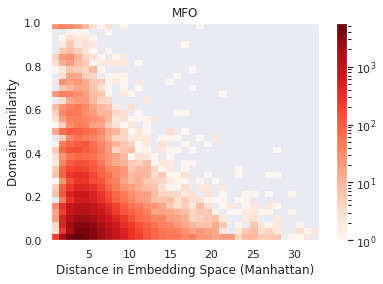

In [3]:
observe_domain_relation(mdl_path='../saved_models/swissprot_mf',
                        domain_mapper_path='../data/processed/domain_mapper_swissprot_mf.p',
                        go_mapper_path='../data/processed/go_mapper_swissprot_mf.p',
                        all_protein_domains_path='../data/processed/all_protein_domains_swissprot_mf.p',
                        all_protein_gos_path='../data/processed/all_protein_gos_swissprot_mf.p',
                        all_domain_proteins_path='../data/processed/all_domain_proteins_swissprot_mf.p',
                        all_go_proteins_path='../data/processed/all_go_proteins_swissprot_mf.p',
                        all_domains_path='../data/processed/all_domains_swissprot_mf.p',
                        rand_count=100000,
                        onto='MF')

### Observe BP

100%|██████████| 100000/100000 [00:21<00:00, 4697.82it/s]


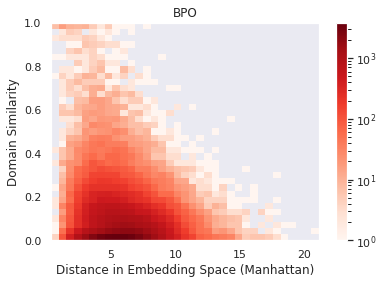

In [4]:
observe_domain_relation(mdl_path='../saved_models/swissprot_bp',
                        domain_mapper_path='../data/processed/domain_mapper_swissprot_bp.p',
                        go_mapper_path='../data/processed/go_mapper_swissprot_bp.p',
                        all_protein_domains_path='../data/processed/all_protein_domains_swissprot_bp.p',
                        all_protein_gos_path='../data/processed/all_protein_gos_swissprot_bp.p',
                        all_domain_proteins_path='../data/processed/all_domain_proteins_swissprot_bp.p',
                        all_go_proteins_path='../data/processed/all_go_proteins_swissprot_bp.p',
                        all_domains_path='../data/processed/all_domains_swissprot_bp.p',
                        rand_count=100000,
                        onto='BP')

### Observe CC

100%|██████████| 100000/100000 [00:05<00:00, 16834.43it/s]


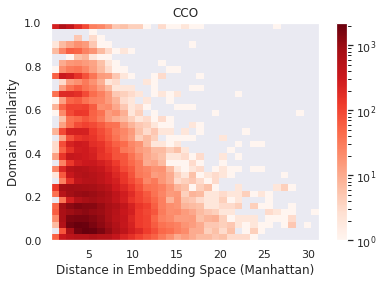

In [5]:
observe_domain_relation(mdl_path='../saved_models/swissprot_cc',
                        domain_mapper_path='../data/processed/domain_mapper_swissprot_cc.p',
                        go_mapper_path='../data/processed/go_mapper_swissprot_cc.p',
                        all_protein_domains_path='../data/processed/all_protein_domains_swissprot_cc.p',
                        all_protein_gos_path='../data/processed/all_protein_gos_swissprot_cc.p',
                        all_domain_proteins_path='../data/processed/all_domain_proteins_swissprot_cc.p',
                        all_go_proteins_path='../data/processed/all_go_proteins_swissprot_cc.p',
                        all_domains_path='../data/processed/all_domains_swissprot_cc.p',
                        rand_count=100000,
                        onto='CC')